# SHAP values 2020-21

Notebook for digging into any predictions made by the FFS model

## Set-up

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pyarrow.parquet as pq

In [2]:
os.chdir('..')

In [3]:
from src.models.DeepFantasyFootball.make_predictions import DeepFantasyFootball, load_live_data
from src.models.constants import SEASON_ORDER_DICT

Using TensorFlow backend.


In [4]:
pd.options.display.max_columns = None

In [5]:
shap.initjs()

In [6]:
# from src.data.s3_utilities import s3_filesystem

In [7]:
# gw1_predictions = pq.read_table('s3://fpl-analysis-data/gw_predictions/season=2020-21/gw=1/2020-21-1.parquet', filesystem=s3_filesystem).to_pandas()
# gw1_predictions.head()

In [8]:
RANDOM_SEED = 3

## Make predictions

In [9]:
SEASON_ORDER_DICT

{'2011-12': -4,
 '2012-13': -3,
 '2013-14': -2,
 '2014-15': -1,
 '2015-16': 0,
 '2016-17': 1,
 '2017-18': 2,
 '2018-19': 3,
 '2019-20': 4,
 '2020-21': 5}

In [10]:
%%time
live_data = load_live_data()

2020-09-07 19:25:27,417 - Loading historical FFS data
2020-09-07 19:25:33,764 - Loaded historical FFS data of shape (92410, 66)
2020-09-07 19:25:33,765 - Loading latest FFS data
2020-09-07 19:25:34,151 - No data for 2020-2021 available, returning empty DataFrame for latest FFS data
2020-09-07 19:25:34,154 - Loaded latest FFS data of shape: Empty DataFrame
Columns: []
Index: []
2020-09-07 19:25:34,217 - Combined FFS data shape:       Team  Aerial Duels - Won - Percentage  Assists  Big Chances Created  \
0      ARS                             75.0        0                    0   
1      QPR                             40.0        0                    0   
2      ARS                              0.0        0                    0   
3      MUN                              0.0        0                    0   
4      CHE                              0.0        0                    1   
...    ...                              ...      ...                  ...   
92405  EVE                    

CPU times: user 1.93 s, sys: 795 ms, total: 2.72 s
Wall time: 14.6 s


In [11]:
print(live_data.shape)
live_data.head()

(176265, 66)


,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points,season_order
0,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,2.45,2.41,1.0,0.0,0.0,1.21,0.0,0,0,1,0,0,0,0.0,4
25,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0.0,2.30,2.29,1.0,0.0,0.0,1.34,1.0,0,0,1,0,0,0,0.0,4
50,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0.0,10.67,0.09,0.0,0.0,1.0,30.23,1.0,0,0,1,0,0,0,0.0,4
75,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.00,100.0,0.0,100.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0,4,0.0,2.40,2.67,1.0,0.0,0.0,1.14,0.0,1,0,1,0,0,0,1.0,4
100,aaron_connolly,Brighton and Hove Albion,2019-20,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.2,0.0,0.0,0.0,0.0,2.0,0.14,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,3.0,2.0,0,5,0.0,2.22,1.40,0.0,0.0,0.0,2.26,1.0,0,0,1,0,0,0,1.0,4


In [15]:
# Remove sides relegated in 2019-20
live_data = live_data.copy()[~live_data['team_name'].isin(['Bournemouth', 'Watford', 'Norwich City'])]

In [16]:
PREVIOUS_GW = 38
PREDICTION_SEASON = '2019-20'
PREDICTION_SEASON_ORDER = SEASON_ORDER_DICT[PREDICTION_SEASON]

In [17]:
lstm_pred = DeepFantasyFootball(
    previous_gw=PREVIOUS_GW,
    prediction_season_order=PREDICTION_SEASON_ORDER,
    previous_gw_was_double_gw=False  # Remove parameter
)

In [18]:
player_list, player_data_list = lstm_pred.prepare_data_for_lstm(full_data=live_data)

2020-09-07 19:27:44,560 - Number of players available for selection: 59764.0
2020-09-07 19:27:44,735 - Player data shape before: (59764, 66)
2020-09-07 19:27:44,870 - Player data shape after removing players with insufficient GW data: (59764, 66)
2020-09-07 19:27:45,342 - Player data shape after only keeping records needed for LSTM: (2170, 66)


In [19]:
unformatted_predictions = lstm_pred.make_player_predictions(
    player_data_list=player_data_list
)

2020-09-07 19:27:48,953 - LSTM input array shape: (434, 5, 62)


In [20]:
final_predictions = lstm_pred.format_predictions(
    player_list=player_list,
    final_predictions=unformatted_predictions,
    full_data=live_data,
    double_gw_teams=[]
)

In [21]:
final_predictions.head()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name
303,5.075146,5.092616,5.211412,5.165265,5.033514,25.577951,mohamed_salah,0,0,0,1,Liverpool
352,4.756026,5.081492,4.871556,4.859748,4.750829,24.319649,raheem_sterling,0,0,0,1,Manchester City
156,4.645730,4.668086,4.687150,4.619520,4.524433,23.144918,harry_kane,0,1,0,0,Tottenham Hotspur
22,5.086726,4.402718,4.415713,4.244442,4.093112,22.242708,andrew_robertson,1,0,0,0,Liverpool
165,4.495390,4.342297,4.314149,4.194885,4.088865,21.435585,hugo_lloris,0,0,1,0,Tottenham Hotspur


In [22]:
final_predictions[final_predictions['sum'].isnull()]  #['team_name'].unique()

,GW_plus_1,GW_plus_2,GW_plus_3,GW_plus_4,GW_plus_5,sum,name,position_DEF,position_FWD,position_GK,position_MID,team_name


In [23]:
plot_df = pd.melt(
    final_predictions[['name', 'GW_plus_1', 'GW_plus_2', 'GW_plus_3', 'GW_plus_4', 'GW_plus_5']], 
    id_vars=['name']
)
plot_df.rename(columns={'variable': 'GW', 'value': 'prediction'}, inplace=True)
plot_df.head()

,name,GW,prediction
0,mohamed_salah,GW_plus_1,5.075146
1,raheem_sterling,GW_plus_1,4.756026
2,harry_kane,GW_plus_1,4.645730
3,andrew_robertson,GW_plus_1,5.086726
4,hugo_lloris,GW_plus_1,4.495390


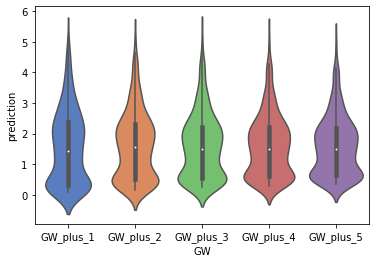

In [24]:
sns.violinplot(x="GW", y="prediction", data=plot_df, palette="muted", split=True)
plt.show()

In [31]:
top100_prediction_players = list(final_predictions.head(100)['name'])

## SHAP values

### Feature importance

In [32]:
player_data_list[0].shape

(5, 62)

In [33]:
player_data_list[0]

,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points
33,0.000,0.0,0.181818,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.125,0.000000,0.000000,0.009132,0.0,0.0,0.0,0.000000,0.133333,0.016077,1.0,0.0,1.00,0.039474,0.000000,0.0,0.0,0.06250,0.0,0.000,0.00,0.000000,0.0,0.5,0.0,0.090909,0.000000,0.0,0.0,0.105556,0.034783,0.083333,0.0,0.891892,0.0,0.312598,0.004815,0.5,0.0,0.5,0.340957,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.161290
34,0.000,0.0,0.181818,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500,0.000000,0.004762,0.004566,0.0,0.0,0.0,0.000000,0.327778,0.000000,1.0,0.0,1.00,0.065789,0.006944,0.0,0.0,0.03125,0.0,0.000,0.00,0.000000,0.5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.327778,0.026087,0.041667,0.0,0.918919,0.0,0.038583,0.036112,0.0,0.0,0.0,0.067108,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.161290
35,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.945946,0.0,0.048031,0.087872,0.5,0.0,0.0,0.027686,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
36,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.972973,0.0,0.035433,0.047246,0.0,0.0,0.0,0.051159,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
37,0.167,0.0,0.181818,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,0.2,0.125,0.333333,0.009524,0.289954,0.0,0.0,0.0,0.494444,0.200000,0.218650,0.7,1.0,0.71,0.065789,0.013889,0.0,0.0,0.00000,0.0,0.333,0.25,0.222222,0.5,0.0,1.0,0.000000,0.055556,1.0,0.0,0.494444,0.121739,0.250000,0.0,1.000000,0.0,0.091339,0.018357,0.5,0.0,0.5,0.117665,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.322581


In [34]:
input_data_columns = list(player_data_list[0].columns)

In [35]:
# Order of columns after reshaping to 2D
input_data_columns_flattened = \
    [col + '_minus5' for col in input_data_columns] + \
    [col + '_minus4' for col in input_data_columns] + \
    [col + '_minus3' for col in input_data_columns] + \
    [col + '_minus2' for col in input_data_columns] + \
    [col + '_minus1' for col in input_data_columns]

In [36]:
flattened_df = pd.DataFrame(
    player_data_list[0].values.reshape(1, -1),
    columns=input_data_columns_flattened
)

flattened_df

,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

In [37]:
reconstructed_df = pd.DataFrame(
    flattened_df.values.reshape(5, -1),
    columns=input_data_columns
)

reconstructed_df

,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points
0,0.000,0.0,0.181818,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.071429,0.0,0.125,0.000000,0.000000,0.009132,0.0,0.0,0.0,0.000000,0.133333,0.016077,1.0,0.0,1.00,0.039474,0.000000,0.0,0.0,0.06250,0.0,0.000,0.00,0.000000,0.0,0.5,0.0,0.090909,0.000000,0.0,0.0,0.105556,0.034783,0.083333,0.0,0.891892,0.0,0.312598,0.004815,0.5,0.0,0.5,0.340957,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.161290
1,0.000,0.0,0.181818,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.500,0.000000,0.004762,0.004566,0.0,0.0,0.0,0.000000,0.327778,0.000000,1.0,0.0,1.00,0.065789,0.006944,0.0,0.0,0.03125,0.0,0.000,0.00,0.000000,0.5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.327778,0.026087,0.041667,0.0,0.918919,0.0,0.038583,0.036112,0.0,0.0,0.0,0.067108,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.161290
2,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.945946,0.0,0.048031,0.087872,0.5,0.0,0.0,0.027686,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
3,0.000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.000,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.972973,0.0,0.035433,0.047246,0.0,0.0,0.0,0.051159,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.129032
4,0.167,0.0,0.181818,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,0.2,0.125,0.333333,0.009524,0.289954,0.0,0.0,0.0,0.494444,0.200000,0.218650,0.7,1.0,0.71,0.065789,0.013889,0.0,0.0,0.00000,0.0,0.333,0.25,0.222222,0.5,0.0,1.0,0.000000,0.055556,1.0,0.0,0.494444,0.121739,0.250000,0.0,1.000000,0.0,0.091339,0.018357,0.5,0.0,0.5,0.117665,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.322581


In [38]:
# Check reconstructed data:
for col in input_data_columns:
    np.testing.assert_array_equal(
        player_data_list[0][col],
        reconstructed_df[col]
    )

__Create input array for LSTM by doing above steps for all DataFrames in `player_data_list`__

In [39]:
player_data_flattened_list = [
    pd.DataFrame(
        df.values.reshape(1, -1),
        columns=input_data_columns_flattened
    ) 
    for df in player_data_list
]

player_data_flattened_df = pd.concat(player_data_flattened_list, ignore_index=True)
print(player_data_flattened_df.shape)
player_data_flattened_df.head()

(434, 310)


,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

In [40]:
# Array passed to SHAP functions
lstm_input_array = player_data_flattened_df.values

__Check reconstruction of data from `lstm_input_array`__

In [41]:
player_data_list_reconstructed_test = [
    pd.DataFrame(
        input_array.reshape(5, -1),
        columns=input_data_columns
    ) 
    for input_array 
    in np.array_split(  # Split array into individual flat row arrays
        lstm_input_array,
        lstm_input_array.shape[0]
    )
]

In [42]:
len(player_data_list_reconstructed_test)

434

In [43]:
# Check reconstructed data
reconstructed_concat = pd.concat(player_data_list_reconstructed_test, ignore_index=True)
original_concat = pd.concat(player_data_list, ignore_index=True)

for col in input_data_columns:
    np.testing.assert_array_equal(
        reconstructed_concat[col],
        original_concat[col]
    )

__Create wrapper function around `lstm_pred.make_player_predictions`__

In [44]:
def make_predictions(input_array_2d):
    """
    Wrapper around make_player_predictions which includes the additional step of converting the 2D input array to a list of 3D arrays for each player.
    """
    # 2D input array to list of 3D arrays:
    player_data_list_reconstructed = [
        pd.DataFrame(
            input_array.reshape(5, -1),
            columns=input_data_columns
        ) 
        for input_array 
        in np.array_split(
            input_array_2d,
            input_array_2d.shape[0]
        )
    ]
    
    # Make predictions:
    raw_predictions = lstm_pred.make_player_predictions(
        player_data_list=player_data_list_reconstructed
    )
    
    return raw_predictions['GW_plus_1']

In [45]:
# Test function
make_predictions(lstm_input_array)

2020-09-07 19:30:47,960 - LSTM input array shape: (434, 5, 62)


0      2.264728
1      1.216349
2      0.146408
3      1.020865
4      2.891557
         ...   
429    0.463691
430    0.198612
431    2.503919
432    1.464248
433    0.266854
Name: GW_plus_1, Length: 434, dtype: float32

In [46]:
lstm_input_array.shape

(434, 310)

In [47]:
lstm_input_array

array([[0.        , 0.        , 0.18181818, ..., 0.        , 0.        ,
        0.32258065],
       [0.5       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12903226],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.12903226],
       ...,
       [0.5       , 0.        , 0.        , ..., 1.        , 0.        ,
        0.19354839],
       [0.        , 0.        , 0.27272727, ..., 1.        , 0.        ,
        0.35483871],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.12903226]])

In [48]:
np.random.seed(RANDOM_SEED)
idx = np.random.randint(lstm_input_array.shape[0], size=100)  # Use 100 random examples in background data
idx

array([362, 152, 249, 131, 256, 277, 147, 202, 363, 169, 138, 405, 119,
       422, 148, 428,  93, 423, 398,  26, 337, 150, 322, 258, 316, 129,
       346,  69, 360, 110,  97, 413, 106, 152, 318,   7, 171,  33, 379,
       335, 176, 293,  20, 350,  49, 405, 383, 206,  28, 375,  54,   0,
       192, 274, 372, 165, 184, 165, 253, 174,  33, 113,   1, 341, 117,
       375, 235, 380,  99, 219, 400, 336, 160, 400, 274, 331, 183, 352,
       223, 141, 421, 414,  48, 289, 308, 242,   2, 156,  36, 346, 232,
       172, 176, 315, 182,  91, 277, 113, 312, 104])

In [49]:
background_data = lstm_input_array[idx, :]
background_data.shape

(100, 310)

In [50]:
explainer = shap.KernelExplainer(make_predictions, background_data.astype(np.float32))

2020-09-07 19:30:56,525 - LSTM input array shape: (100, 5, 62)


In [65]:
# Turn off logs
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [144]:
lstm_input_array.shape

(434, 310)

## Top 100 players

### Aggregate view

In [60]:
player_idx_list = []

for player in top100_prediction_players:
    player_idx = player_list.index(player)
    player_idx_list.append(player_idx)

In [61]:
top100_input_data = lstm_input_array[player_idx_list, :]

In [62]:
top100_input_data.shape

(100, 310)

In [63]:
top100_input_data

array([[0.5       , 0.25      , 0.        , ..., 1.        , 1.        ,
        0.16129032],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.38709677],
       [0.6       , 0.        , 0.18181818, ..., 0.        , 1.        ,
        0.32258065],
       ...,
       [0.5       , 0.        , 0.        , ..., 1.        , 0.        ,
        0.29032258],
       [0.5       , 0.        , 0.09090909, ..., 0.        , 0.        ,
        0.16129032],
       [0.        , 0.        , 0.09090909, ..., 0.        , 0.        ,
        0.29032258]])

In [66]:
shap_values = explainer.shap_values(
    top100_input_data.astype(np.float32)
)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


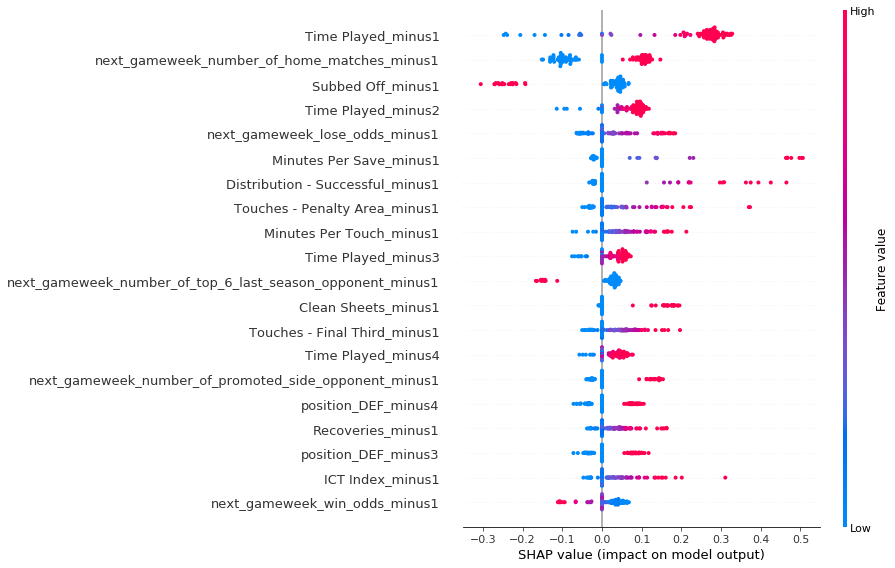

In [143]:
shap.summary_plot(
    shap_values,
    features=top100_input_data.astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [146]:
shap_values.shape

(100, 310)

In [147]:
len(input_data_columns_flattened)

310

In [148]:
shap_df = pd.DataFrame(shap_values, columns=input_data_columns_flattened)
shap_df.head()

,Aerial Duels - Won - Percentage_minus5,Assists_minus5,Bad Touches_minus5,Big Chances Created_minus5,Caught Offside_minus5,Chances From Counter Attack_minus5,Clean Sheets_minus5,Crosses - Open Play - Successful_minus5,Crosses - Unsuccessful_minus5,Distribution - Successful_minus5,Dribbles - Successful Percentage_minus5,Fouls_minus5,Goals_minus5,Goals Conceded_minus5,Handballs_minus5,ICT Creativity_minus5,ICT Index_minus5,Minutes Per Block_minus5,Minutes Per Interception_minus5,Minutes Per Save_minus5,Minutes Per Tackle Won_minus5,Minutes Per Touch_minus5,xGI Expected Goal Involvement_minus5,Pass Completion_minus5,Pass Completion - Final Third_minus5,Pass Completion - Opponents Half_minus5,Passes - Backward_minus5,Passes - Forward_minus5,Premier League Straight Red Cards_minus5,Premier League Total Red Cards_minus5,Recoveries_minus5,Saves (Shots Outside Box)_minus5,Shot Accuracy_minus5,Shots Blocked_minus5,Shots On Target_minus5,Subbed Off_minus5,Subbed On_minus5,Tackles - Won - Percentage_minus5,Tackles Lost_minus5,Take Ons_minus5,Take Ons - Successful Percentage_minus5,Throw Ins_minus5,Time Played_minus5,Touches - Final Third_minus5,Touches - Penalty Area_minus5,double_gameweek_minus5,gw_minus5,next_gameweek_double_gameweek_minus5,next_gameweek_draw_odds_minus5,next_gameweek_lose_odds_minus5,next_gameweek_number_of_home_matches_minus5,next_gameweek_number_of_promoted_side_opponent_minus5,next_gameweek_number_of_top_6_last_season_opponent_minus5,next_gameweek_win_odds_minus5,number_of_home_matches_minus5,number_of_top_6_last_season_opponent_minus5,position_DEF_minus5,position_FWD_minus5,position_GK_minus5,position_MID_minus5,top_6_last_season_minus5,total_points_minus5,Aerial Duels - Won - Percentage_minus4,Assists_minus4,Bad Touches_minus4,Big Chances Created_minus4,Caught Offside_minus4,Chances From Counter Attack_minus4,Clean Sheets_minus4,Crosses - Open Play - Successful_minus4,Crosses - Unsuccessful_minus4,Distribution - Successful_minus4,Dribbles - Successful Percentage_minus4,Fouls_minus4,Goals_minus4,Goals Conceded_minus4,Handballs_minus4,ICT Creativity_minus4,ICT Index_minus4,Minutes Per Block_minus4,Minutes Per Interception_minus4,Minutes Per Save_minus4,Minutes Per Tackle Won_minus4,Minutes Per Touch_minus4,xGI Expected Goal Involvement_minus4,Pass Completion_minus4,Pass Completion - Final Third_minus4,Pass Completion - Opponents Half_minus4,Passes - Backward_minus4,Passes - Forward_minus4,Premier League Straight Red Cards_minus4,Premier League Total Red Cards_minus4,Recoveries_minus4,Saves (Shots Outside Box)_minus4,Shot Accuracy_minus4,Shots Blocked_minus4,Shots On Target_minus4,Subbed Off_minus4,Subbed On_minus4,Tackles - Won - Percentage_minus4,Tackles Lost_minus4,Take Ons_minus4,Take Ons - Successful Percentage_minus4,Throw Ins_minus4,Time Played_minus4,Touches - Final Third_minus4,Touches - Penalty Area_minus4,double_gameweek_minus4,gw_minus4,next_gameweek_double_gameweek_minus4,next_gameweek_draw_odds_minus4,next_gameweek_lose_odds_minus4,next_gameweek_number_of_home_matches_minus4,next_gameweek_number_of_promoted_side_opponent_minus4,next_gameweek_number_of_top_6_last_season_opponent_minus4,next_gameweek_win_odds_minus4,number_of_home_matches_minus4,number_of_top_6_last_season_opponent_minus4,position_DEF_minus4,position_FWD_minus4,position_GK_minus4,position_MID_minus4,top_6_last_season_minus4,total_points_minus4,Aerial Duels - Won - Percentage_minus3,Assists_minus3,Bad Touches_minus3,Big Chances Created_minus3,Caught Offside_minus3,Chances From Counter Attack_minus3,Clean Sheets_minus3,Crosses - Open Play - Successful_minus3,Crosses - Unsuccessful_minus3,Distribution - Successful_minus3,Dribbles - Successful Percentage_minus3,Fouls_minus3,Goals_minus3,Goals Conceded_minus3,Handballs_minus3,ICT Creativity_minus3,ICT Index_minus3,Minutes Per Block_minus3,Minutes Per Interception_minus3,Minutes Per Save_minus3,Minutes Per Tackle Won_minus3,Minutes Per Touch_minus3,xGI Expected Goal Involvement_minus3,Pass Com

Feature importance is the ranking of mean absolute SHAP values for each feature

In [149]:
np.abs(shap_df).mean().sort_values(ascending=False)

Time Played_minus1                             0.244771
next_gameweek_number_of_home_matches_minus1    0.097565
Subbed Off_minus1                              0.082449
Time Played_minus2                             0.080132
next_gameweek_lose_odds_minus1                 0.053343
                                                 ...   
Premier League Total Red Cards_minus3          0.000000
gw_minus3                                      0.000000
double_gameweek_minus3                         0.000000
next_gameweek_double_gameweek_minus5           0.000000
gw_minus4                                      0.000000
Length: 310, dtype: float64

Plot feature importance using all time periods of feature

In [150]:
shap_df = shap_df.T.reset_index().rename(columns={'index': 'time_feature'})
shap_df.head()

,time_feature,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,Aerial Duels - Won - Percentage_minus5,0.003118,0.0,0.000000,0.0,0.007451,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.001185,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.007055,0.009246,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.01286,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.007886,0.0,0.000000,0.000000,0.0,0.00396,0.0,0.000000
1,Assists_minus5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.033790,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.034426,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.002019,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000
2,Bad Touches_minus5,0.000000,0.0,0.010234,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.018135,0.042091,0.036531,0.0,0.027209,0.000000,0.0,0.0,0.007675,0.0,0.019614,0.037271,0.0,0.0,0.054616,0.0,0.0,0.0,0.0,0.037784,0.0,0.01209,0.0,0.007784,0.0,0.00875,0.0,0.021925,0.0,0.0,0.0,0.008534,0.000000,0.0,0.0,0.0,0.023674,0.0,0.049154,0.0,0.0,0.0,0.0,0.0,0.007936,0.0,0.0,0.00791,0.027262,0.0,0.010352,0.0,0.000000,0.009397,0.0,0.0,0.018239,0.010557,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,-0.015101,0.012272,0.0,0.0,0.0,0.048963,0.059017,0.0,0.025903,0.053807,-0.012835,0.0084,0.0,0.000000,0.0,0.016254,0.030570,0.0,0.00000,0.0,0.000000
3,Big Chances Created_minus5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.022221,0.015238,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.006190,0.0,0.000000,0.000000,0.0,0.0,0.012266,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,0.037713,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.017020,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.016882,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.001085,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000
4,Caught Offside_minus5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.012597,0.008106,0.0,0.0,0.0,0.0,0.000000,0.000000,0.051266,0.0,0.007655,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.00000,0.0,-0.000831,0.0,0.0,0.0,0.000000,0.009457,0.0,0.0,0.0,0.000000,0.0,0.085762,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.032850,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.031548,0.000000,0.0,0.0,-0.006929,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.031548,0.0,0.000000,0.037928,0.0,0.00000,0.0,0.029327


In [151]:
shap_df['feature'] = shap_df['time_feature'].str.rsplit('_', 1).apply(lambda x: x[0])

1. Groupby feature, sum SHAP values
2. Take mean of _absolute_ SHAP values for each feature
3. Sort

In [152]:
feature_importance = np.abs(
    shap_df.groupby('feature').sum()
).T.mean().sort_values(ascending=False)

feature_importance

feature
Time Played                             0.393233
Touches - Final Third                   0.134332
position_DEF                            0.117379
next_gameweek_number_of_home_matches    0.107741
Subbed Off                              0.099257
                                          ...   
Minutes Per Block                       0.001572
Handballs                               0.001526
double_gameweek                         0.000000
gw                                      0.000000
next_gameweek_double_gameweek           0.000000
Length: 62, dtype: float64

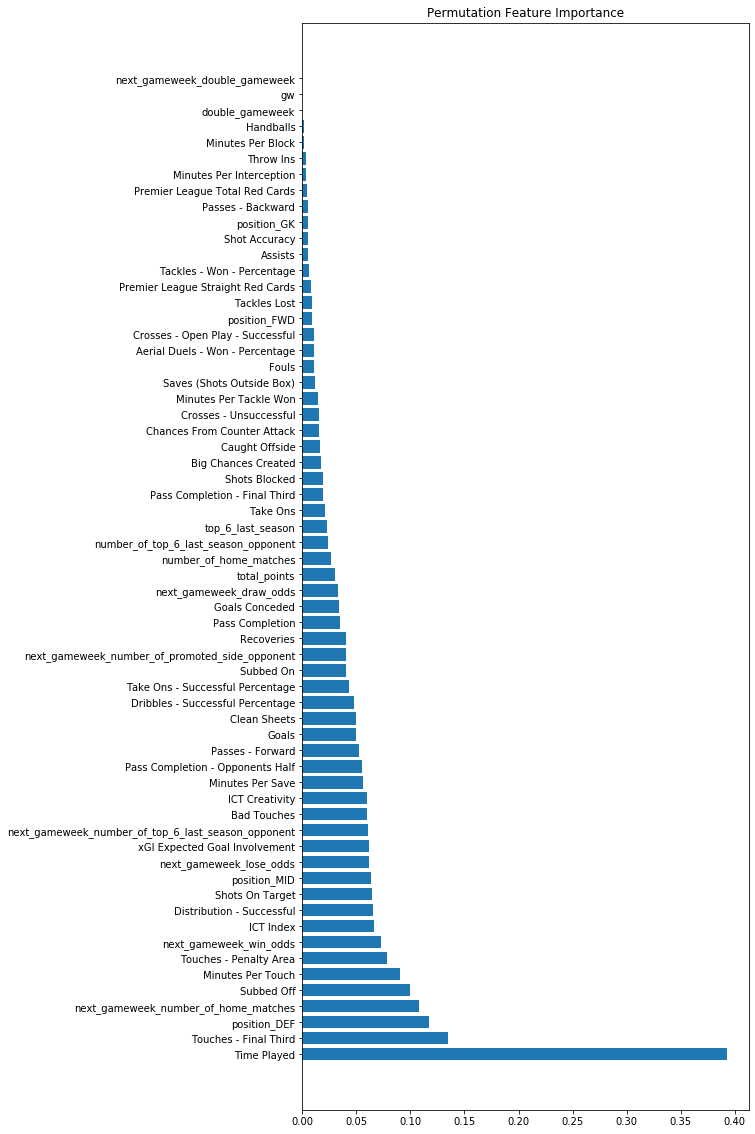

In [153]:
plt.figure(figsize=(8, 20))
plt.barh(
    feature_importance.index, 
    feature_importance.values
)
plt.title('Permutation Feature Importance')
plt.show()

### Individual player predictions

In [154]:
shap_values.shape

(100, 310)

In [155]:
top100_prediction_players

['mohamed_salah',
 'raheem_sterling',
 'harry_kane',
 'andrew_robertson',
 'hugo_lloris',
 'ederson_santana de moraes',
 'kevin_de bruyne',
 'alisson_ramses becker',
 'gabriel_fernando de jesus',
 'jamie_vardy',
 'bruno_miguel borges fernandes',
 'david_de gea',
 'anthony_martial',
 'riyad_mahrez',
 'david_silva',
 'michail_antonio',
 'pierre-emerick_aubameyang',
 'emiliano_martinez',
 'danny_ings',
 'virgil_van dijk',
 'rui_pedro dos santos patrício',
 'sadio_mane',
 'marcus_rashford',
 'kasper_schmeichel',
 'olivier_giroud',
 'roberto_firmino barbosa de oliveira',
 'joão_pedro cavaco cancelo',
 'mathew_ryan',
 'christian_pulisic',
 'dean_henderson',
 'lukasz_fabianski',
 'kyle_walker',
 'heung-min_son',
 'joseph_gomez',
 'nick_pope',
 'nathan_redmond',
 'georginio_wijnaldum',
 'wilfried_zaha',
 'césar_azpilicueta',
 'mason_mount',
 'alex_mccarthy',
 'willian_borges da silva',
 'jordan_pickford',
 'martin_dubravka',
 'phil_foden',
 'jack_grealish',
 'chris_wood',
 'raul_alonso jimenez rodriguez',
 'kieran_tierney',
 'james_ward-prowse',
 'trent_alexander-arnold',
 'harry_maguire',
 'jay_rodriguez',
 'vicente_guaita',
 'toby_alderweireld',
 'ben_davies',
 'josé_reina',
 'edward_nketiah',
 'mason_greenwood',
 'che_adams',
 'aymeric_laporte',
 'tomas_soucek',
 'richarlison_de andrade',
 'marcos_alonso',
 'james_justin',
 'serge_aurier',
 'victor_nilsson-lindelof',
 'david_luiz moreira marinho',
 'kurt_zouma',
 'alex_oxlade-chamberlain',
 'mahmoud_hassan',
 'john_egan',
 'tammy_abraham',
 'conor_coady',
 'matt_ritchie',
 'reece_james',
 'ashley_roy westwood',
 'kyle_walker-peters',
 'aaron_wan-bissaka',
 'bernardo_mota veiga de carvalho e silva',
 'jonjo_shelvey',
 'willy_boly',
 'neco_williams',
 'daniel_castelo podence',
 'ayoze_pérez gutiérrez',
 'christian_benteke',
 'youri_tielemans',
 'enda_stevens',
 'harvey_barnes',
 'antonio_rüdiger',
 'lucas_rodrigues moura da silva',
 'brandon_williams',
 'james_tarkowski',
 'mark_noble',
 'scott_dann',
 'alexandre_lacazette',
 'erik_pieters',
 'john_mcginn',
 'george_baldock',
 'neal_maupay']

In [168]:
explainer.expected_value

1.6469191065430642

In [156]:
top100_prediction_players.index('andrew_robertson')

3

In [157]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values[3, :], 
    lstm_input_array[player_idx_list[3], :].astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [158]:
player_shap_values = pd.DataFrame(
    shap_values[3, :].reshape(1, 310), 
    columns=input_data_columns_flattened
).T.reset_index().rename(
    columns={
        'index': 'feature_at_time', 
        0:'shap_value'
    }
)

player_shap_values.sort_values('shap_value', ascending=False, inplace=True)
player_shap_values

,feature_at_time,shap_value
290,Time Played_minus1,0.284419
291,Touches - Final Third_minus1,0.196627
297,next_gameweek_lose_odds_minus1,0.172894
299,next_gameweek_number_of_promoted_side_opponent...,0.147395
105,Touches - Final Third_minus4,0.131618
...,...,...
119,position_FWD_minus4,0.000000
120,position_GK_minus4,0.000000
121,position_MID_minus4,0.000000
124,Aerial Duels - Won - Percentage_minus3,0.000000


In [159]:
player_shap_values['feature'] = player_shap_values['feature_at_time'].str.rsplit('_', 1).apply(lambda x: x[0])

In [160]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).head(20)

,shap_value
feature,
Time Played,0.498792
Touches - Final Third,0.458552
position_DEF,0.364032
ICT Creativity,0.230431
next_gameweek_lose_odds,0.204744
next_gameweek_number_of_home_matches,0.159050
next_gameweek_number_of_promoted_side_opponent,0.147395
Bad Touches,0.137214
Crosses - Unsuccessful,0.128773


In [161]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).sum() + 1.647

shap_value    5.086808
dtype: float64

In [162]:
top100_prediction_players.index('trent_alexander-arnold')

50

In [163]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values[50, :], 
    lstm_input_array[player_idx_list[50], :].astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [164]:
player_shap_values = pd.DataFrame(
    shap_values[50, :].reshape(1, 310), 
    columns=input_data_columns_flattened
).T.reset_index().rename(
    columns={
        'index': 'feature_at_time', 
        0:'shap_value'
    }
)

player_shap_values.sort_values('shap_value', ascending=False, inplace=True)
player_shap_values

,feature_at_time,shap_value
284,Subbed On_minus1,0.150703
297,next_gameweek_lose_odds_minus1,0.140490
299,next_gameweek_number_of_promoted_side_opponent...,0.131931
167,Touches - Final Third_minus3,0.108877
298,next_gameweek_number_of_home_matches_minus1,0.105460
...,...,...
132,Crosses - Unsuccessful_minus3,-0.047442
273,Pass Completion - Opponents Half_minus1,-0.060181
174,next_gameweek_number_of_home_matches_minus3,-0.060798
98,Subbed On_minus4,-0.074314


In [165]:
player_shap_values['feature'] = player_shap_values['feature_at_time'].str.rsplit('_', 1).apply(lambda x: x[0])

In [166]:
player_shap_values.groupby('feature').sum().sort_values('shap_value', ascending=False).tail(20)

,shap_value
feature,
Handballs,0.000000
Minutes Per Block,0.000000
Recoveries,0.000000
Minutes Per Save,0.000000
Minutes Per Interception,0.000000
Passes - Backward,0.000000
Premier League Straight Red Cards,0.000000
Premier League Total Red Cards,0.000000
Goals Conceded,-0.031389


In [167]:
live_data[
    (live_data['name'] == 'trent_alexander-arnold') & 
    (live_data['gw'] > PREVIOUS_GW-5) & 
    (live_data['season_order'] == PREDICTION_SEASON_ORDER)
]['Subbed On']

69695    0.0
69720    1.0
69745    0.0
69770    0.0
69795    1.0
Name: Subbed On, dtype: float64

### Players outside top 100

In [138]:
ozil_idx = player_list.index('mesut_ozil')
ozil_idx

297

In [139]:
shap_values_ozil = explainer.shap_values(
    lstm_input_array[ozil_idx, :].astype(np.float32)
)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [140]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(
    explainer.expected_value, 
    shap_values_ozil, 
    lstm_input_array[player_idx_list[50], :].astype(np.float32),
    feature_names=input_data_columns_flattened
)

In [141]:
live_data[
    (live_data['name'] == 'mesut_ozil') & 
    (live_data['gw'] > PREVIOUS_GW-5) & 
    (live_data['season_order'] == PREDICTION_SEASON_ORDER)
]

,name,team_name,season,Aerial Duels - Won - Percentage,Assists,Bad Touches,Big Chances Created,Caught Offside,Chances From Counter Attack,Clean Sheets,Crosses - Open Play - Successful,Crosses - Unsuccessful,Distribution - Successful,Dribbles - Successful Percentage,Fouls,Goals,Goals Conceded,Handballs,ICT Creativity,ICT Index,Minutes Per Block,Minutes Per Interception,Minutes Per Save,Minutes Per Tackle Won,Minutes Per Touch,xGI Expected Goal Involvement,Pass Completion,Pass Completion - Final Third,Pass Completion - Opponents Half,Passes - Backward,Passes - Forward,Premier League Straight Red Cards,Premier League Total Red Cards,Recoveries,Saves (Shots Outside Box),Shot Accuracy,Shots Blocked,Shots On Target,Subbed Off,Subbed On,Tackles - Won - Percentage,Tackles Lost,Take Ons,Take Ons - Successful Percentage,Throw Ins,Time Played,Touches - Final Third,Touches - Penalty Area,double_gameweek,gw,next_gameweek_double_gameweek,next_gameweek_draw_odds,next_gameweek_lose_odds,next_gameweek_number_of_home_matches,next_gameweek_number_of_promoted_side_opponent,next_gameweek_number_of_top_6_last_season_opponent,next_gameweek_win_odds,number_of_home_matches,number_of_top_6_last_season_opponent,position_DEF,position_FWD,position_GK,position_MID,top_6_last_season,total_points,season_order
99481,mesut_ozil,Arsenal,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,34,0.0,2.40,1.77,0.0,0.0,1.0,1.63,1.0,0,0,0,0,1,1,0.0,4
99509,mesut_ozil,Arsenal,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,35,0.0,3.26,0.72,1.0,0.0,1.0,3.52,0.0,1,0,0,0,1,1,0.0,4
99537,mesut_ozil,Arsenal,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,36,0.0,2.74,2.16,0.0,1.0,0.0,1.20,1.0,1,0,0,0,1,1,0.0,4
99565,mesut_ozil,Arsenal,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,37,0.0,2.81,2.61,1.0,0.0,0.0,1.01,0.0,0,0,0,0,1,1,0.0,4
99593,mesut_ozil,Arsenal,2019-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,38,0.0,3.33,4.70,0.0,1.0,0.0,0.58,1.0,0,0,0,0,1,1,0.0,4


## Save top 100 SHAP values for later use

In [169]:
top100_shap_dict = {
    'top100_prediction_players': top100_prediction_players,
    'shap_values': shap_values,
    'explainer': explainer,
    'lstm_input_array': lstm_input_array,
    'input_data_columns_flattened': input_data_columns_flattened
}

In [171]:
import pickle

In [172]:
pickle.dump(top100_shap_dict, open('top100_shap_dict.pickle', 'wb'))

In [173]:
from src.models.utils import _load_model_from_pickle

In [174]:
test = _load_model_from_pickle('top100_shap_dict.pickle')

In [175]:
test['explainer'].expected_value

1.6469191065430642